In [4]:
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
%matplotlib inline

In [5]:
# Load Training Data
    # Load car_images 
car_images = glob.glob('dataset/vehicles/vehicles/dataset*/*.png')
    # Load car_images 
noncar_images = glob.glob('dataset/non-vehicles/non-vehicles/*/*.png')
print(len(car_images), len(noncar_images))

8792 8968


In [6]:
# Define Method to Convert Image to Histogram of Oriented Gradients (HOG)
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [7]:
# Extract HOG Features from an image.
def extract_features(imgs, cspace, orient, 
                        pix_per_cell, cell_per_block, hog_channel):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
        
        # Call bin_spatial() 
        #bin_features = []
        #bin_features = bin_spatial(feature_image, size=(32,32))
        #features.append(bin_features)
        #print(bin_features.shape)
        # Call color_hist()
        #color_features = []
        #color_features = color_hist(feature_image, nbins=32)
        #features.append(color_features)
        #features.append(np.concatenate((hog_features, bin_features, color_features)))
        #X = np.vstack(features).astype(np.float64)
        #X_scaler = StandardScaler().fit(X) 
        #scaled_X = X_scaler.transform(X)
    # Return list of feature vectors
    return features

print('done')

done


In [8]:
import numpy as np
import time
# Feature extraction, orient=11, pix_per_cell=16, cell_per_block=2, hog_channel= 'ALL'
t = time.time()
car_features = extract_features(car_images, 'YUV', 11, 16, 2, 'ALL')
notcar_features = extract_features(noncar_images,  'YUV', 11, 16, 2, 'ALL')
t2 = time.time()
print('Spend time (extract HOG features):', round(t2-t, 2))

Spend time (extract HOG features): 36.72


In [9]:
# Create feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

In [10]:
# Using feature and label to train a SVM Classifier
from sklearn import svm
from sklearn.svm import LinearSVC
clf = LinearSVC()
t_SVM_st = time.time()
clf.fit(X_train, y_train)
t_SVM_end = time.time()
print('Spend time (fit SVC):', round(t_SVM_end-t_SVM_st, 2))
# Check the score of the Linear SVC
print('Accuracy of SVC:', round(clf.score(X_test, y_test), 4))


Spend time (fit SVC): 0.82
Accuracy of SVC: 0.9845


In [29]:
# Define a function - find car in image.
def find_cars(img,ystart,ystop,scale, cspace, pix_per_cell, orient, cell_per_block,clf, show_all_rectangles=False):
    # output
    rectangles = []
    # define rigion of interest
    img = img.astype(np.float32)/255
    img_ROI = img[ystart:ystop,:,:]
    
    # colorspace
    if cspace != 'RGB':
        if cspace == 'HSV':
            img_ROI_cspace = cv2.cvtColor(img_ROI, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            img_ROI_cspace = cv2.cvtColor(img_ROI, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            img_ROI_cspace = cv2.cvtColor(img_ROI, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            img_ROI_cspace = cv2.cvtColor(img_ROI, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            img_ROI_cspace = cv2.cvtColor(img_ROI, cv2.COLOR_RGB2YCrCb)
    else: img_ROI_cspace = np.copy(img_ROI)
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = img_ROI_cspace.shape
        img_ROI_cspace = cv2.resize(img_ROI_cspace, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    channel_1 = img_ROI_cspace[:,:,0]
    channel_2 = img_ROI_cspace[:,:,1]
    channel_3 = img_ROI_cspace[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = ( channel_1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = ( channel_1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # HOG feature
    hog_1 = get_hog_features(channel_1, 11, 16, 2, feature_vec=False)
    hog_2 = get_hog_features(channel_2, 11, 16, 2, feature_vec=False)
    hog_3 = get_hog_features(channel_3, 11, 16, 2, feature_vec=False)
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG Feature
            hog_feat1 = hog_1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog_2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog_3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            test_prediction = clf.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles
    
print('done')

done


In [12]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

print('done')

done


In [13]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

print('done')

done


In [14]:
# Apply a Threshold to the Heatmap
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

print('done')

done


In [21]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

In [43]:
from scipy.ndimage.measurements import label
def process_img(img):


    rects = []

    ystart = 400
    ystop = 464
    scale = 1.0
    rects.append(find_cars(img, ystart, ystop, scale, 'YUV', pix_per_cell, orient, cell_per_block, clf, show_all_rectangles=False))
    ystart = 416
    ystop = 480
    scale = 1.0
    rects.append(find_cars(img, ystart, ystop, scale, 'YUV', pix_per_cell, orient, cell_per_block, clf, show_all_rectangles=False))

    ystart = 400
    ystop = 496
    scale = 1.5
    rects.append(find_cars(img, ystart, ystop, scale, 'YUV', pix_per_cell, orient, cell_per_block, clf, show_all_rectangles=False))
    ystart = 432
    ystop = 528
    scale = 1.5
    rects.append(find_cars(img, ystart, ystop, scale, 'YUV', pix_per_cell, orient, cell_per_block, clf, show_all_rectangles=False))

    ystart = 400
    ystop = 528
    scale = 2.0
    rects.append(find_cars(img, ystart, ystop, scale, 'YUV', pix_per_cell, orient, cell_per_block, clf, show_all_rectangles=False))
    ystart = 432
    ystop = 560
    scale = 2.0
    rects.append(find_cars(img, ystart, ystop, scale, 'YUV', pix_per_cell, orient, cell_per_block, clf, show_all_rectangles=False))
        
    ystart = 400
    ystop = 596
    scale = 3.0
    rects.append(find_cars(img, ystart, ystop, scale, 'YUV', pix_per_cell, orient, cell_per_block, clf, show_all_rectangles=False))
    ystart = 464
    ystop = 660
    scale = 3.0
    rects.append(find_cars(img, ystart, ystop, scale, 'YUV', pix_per_cell, orient, cell_per_block, clf, show_all_rectangles=False))


    rectangles = [item for sublist in rects for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 2)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img,labels, heatmap_img

print('done')

done


In [34]:
test_img = mpimg.imread('./test_images/test6.jpg')
ystart = 400
ystop = 656
orient = 11
pix_per_cell = 16
cell_per_block = 2
scale = 1.5
output_img, labels, heatmap_img = process_img(test_img)
plt.imshow(output_img)

/home/qing/anaconda3/envs/py35_qt4/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/qing/anaconda3/envs/py35_qt4/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/qing/anaconda3/envs/py35_qt4/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.resh

/home/qing/anaconda3/envs/py35_qt4/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/qing/anaconda3/envs/py35_qt4/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/qing/anaconda3/envs/py35_qt4/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.resh

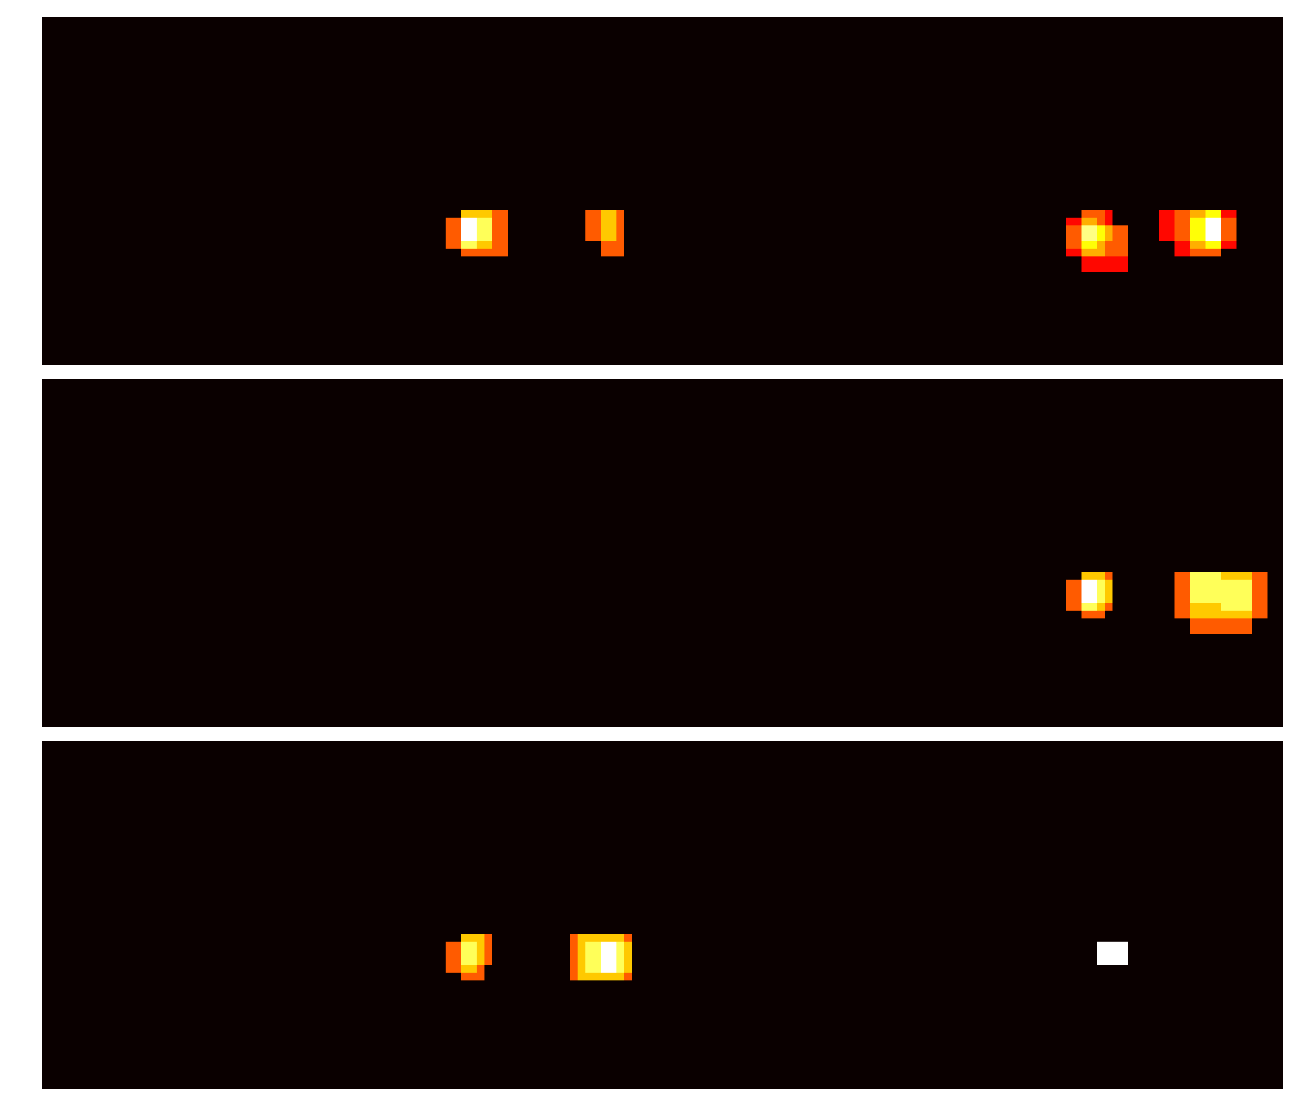

In [46]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    output_img, labels, heatmap_img = process_img(mpimg.imread(im))
    axs[i].imshow(heatmap_img, cmap = 'hot')
    axs[i].axis('off')

/home/qing/anaconda3/envs/py35_qt4/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/qing/anaconda3/envs/py35_qt4/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/qing/anaconda3/envs/py35_qt4/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.resh

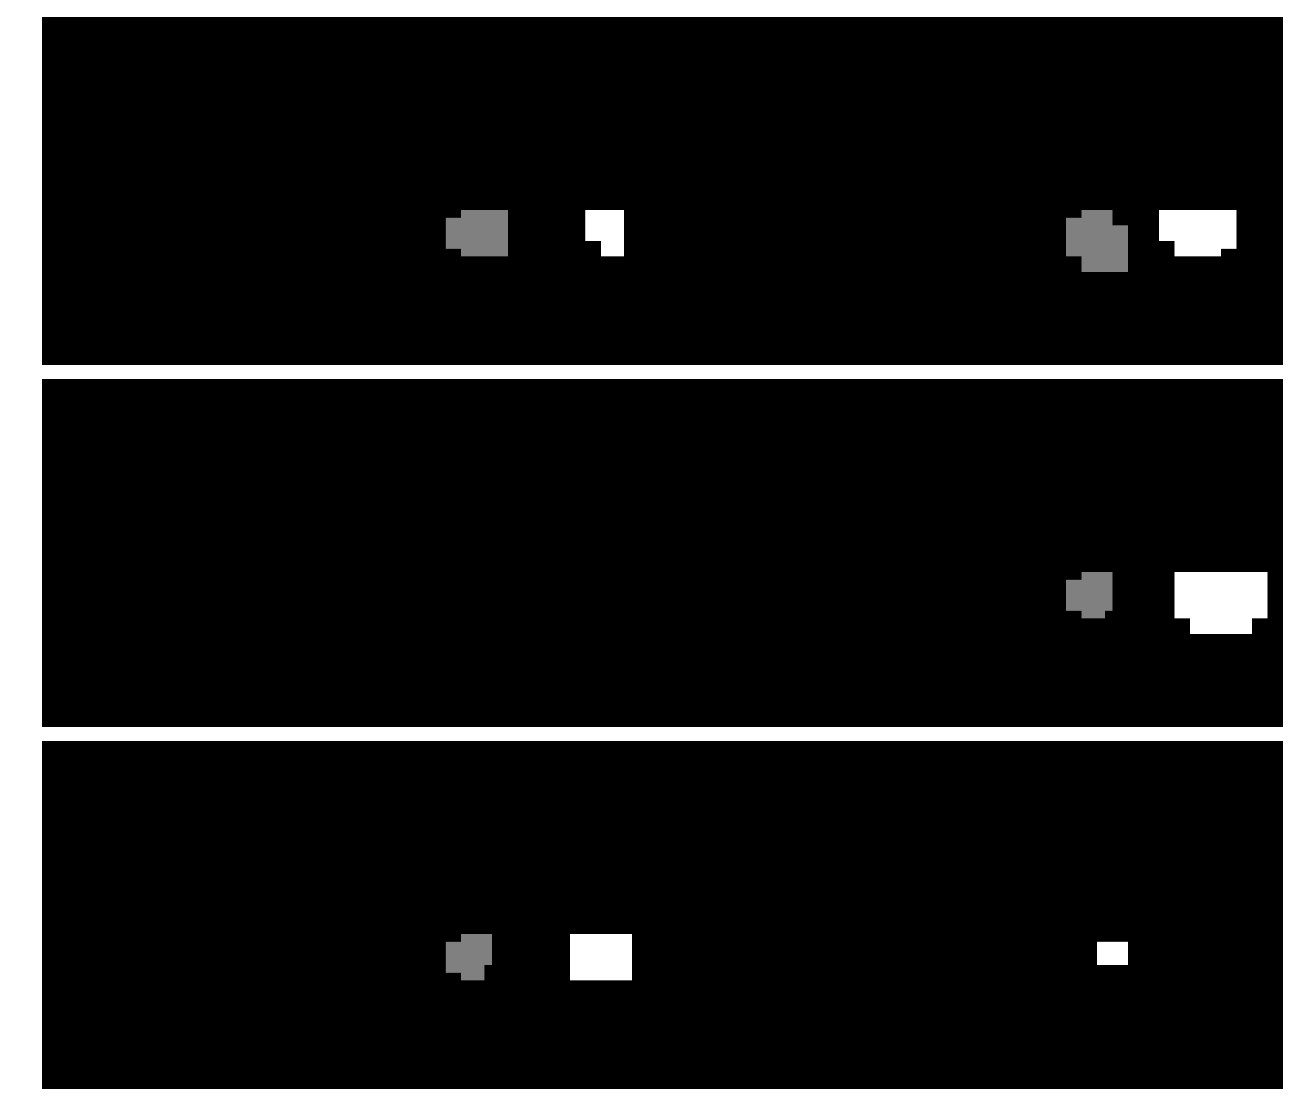

In [48]:
fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    output_img, labels, heatmap_img = process_img(mpimg.imread(im))
    axs[i].imshow(labels[0], cmap = 'gray')
    axs[i].axis('off')

/home/qing/anaconda3/envs/py35_qt4/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/qing/anaconda3/envs/py35_qt4/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/qing/anaconda3/envs/py35_qt4/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.resh

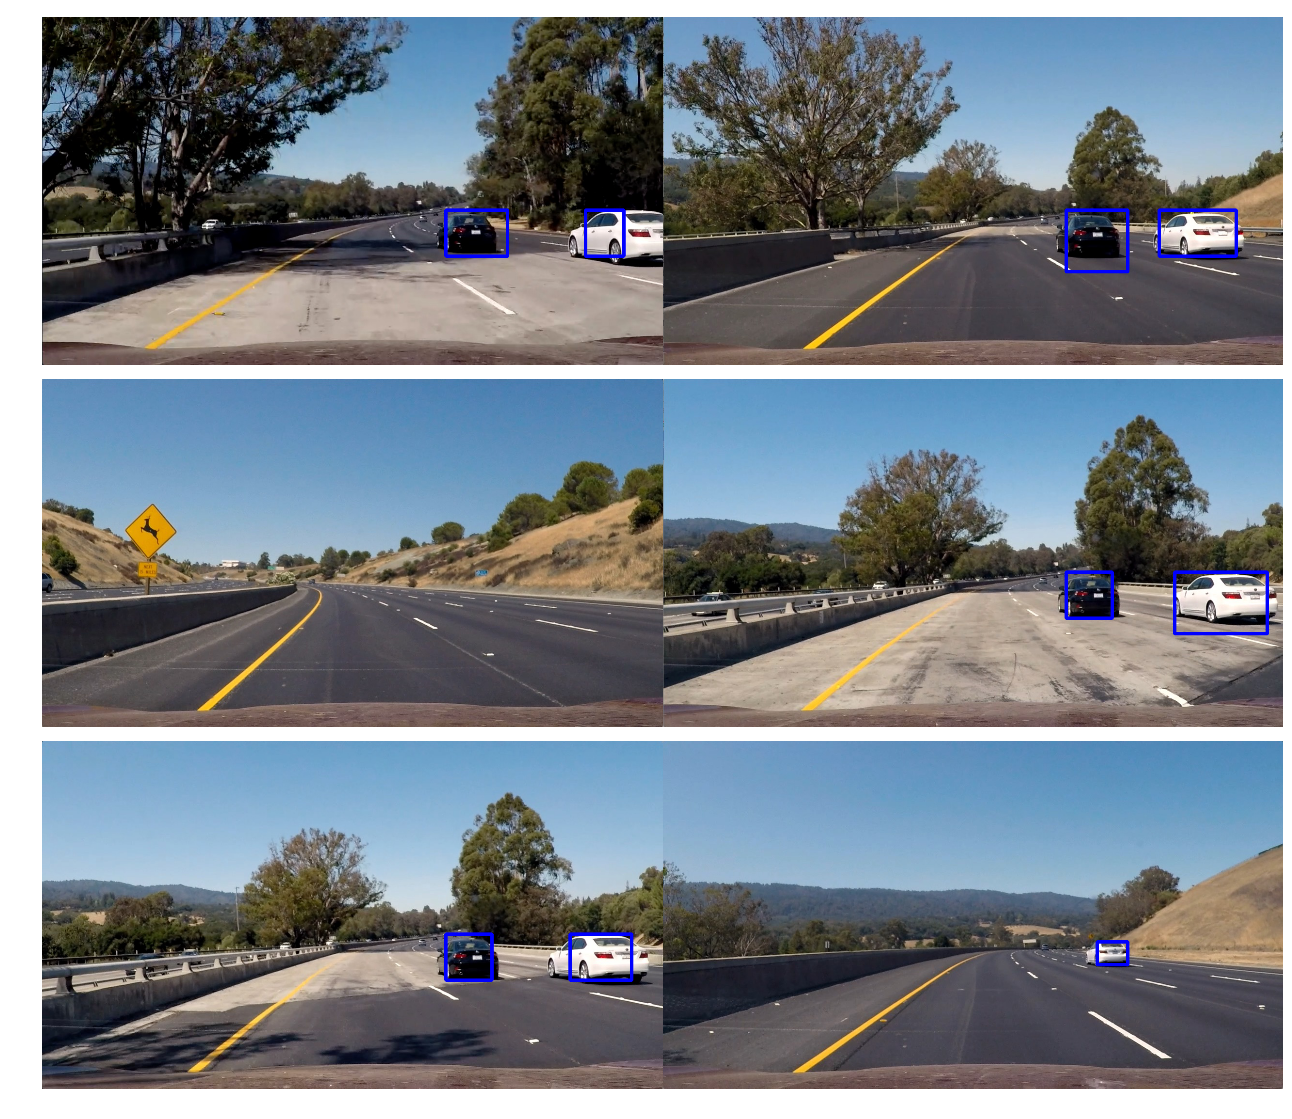

In [45]:


fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    output_img, labels, heatmap_img = process_img(mpimg.imread(im))
    axs[i].imshow(output_img)
    axs[i].axis('off')

In [ ]:
from moviepy.editor import VideoFileClip
test_out_file = 'video_out/project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(process_img)
%time clip_test_out.write_videofile(test_out_file, audio=False)